# fastai MultiLabel Classification using Kfold Cross Validation

The problem I have considered is Multi Label classification. In addition to having multiple labels in each image, the other challenge in this problem is the existence of rare classes and combinations of different classes. So in this situation normal split or random split doesnt work because you can end up putting rare cases in the validation set and your model will never learn about them. The stratification present in the scikit-learn is also not equipped to deal with multilabel targets. 

I have specifically choosen this problem because we may learn some techniques on the way, which we otherwise would not have thought of.

**There may be better or easy way of doing kfold cross validation but I have done it keeping in mind how to implement using fastai**, so if you know some better way so please mail or tweet the idea, i will try to implement and give you credit.

## Install all the necessary libraries

I am using fastai2 so import that. 


In [ ]:
!pip install -q fastai2

### Cross Validation

Cross-validation, how I see it, is the idea of minimizing randomness from one split by makings n folds, each fold containing train and validation splits. You train the model on each fold, so you have n models. Then you take average predictions from all models, which supposedly give us more confidence in results.
These we will see in following code. I found iterative-stratification package that provides scikit-learn compatible cross validators with stratification for multilabel data.

**My opinion**: 

---

In my opinion it's more important to make one right split, especially because CV takes n times more to train. Then why did I do it??

I wanted to explore classification using cross validation using fastai, which I didn't find many resources to learn. So if I write this blog it may help people.

fastai has no cross validation split(may be) in their library to work like other functions they provide. It may be because cross validation takes time, so may be it not that useful.

But still in this condition I feel its worth exploring using fastai.









so what is **stratification**??

The splitting of data into folds may be governed by criteria such as ensuring that each fold has the same proportion of observations with a given categorical value, such as the class outcome value. This is called stratified cross-validation

In [ ]:
!pip install -q iterative-stratification

In [ ]:
from fastai2.vision.all import *
from iterstrat.ml_stratifiers import MultilabelStratifiedKFold

Here dataset is of Zero to GANs - Human Protein Classification inclass jovian.ml hosted competition

In [ ]:
path = Path('../input/jovian-pytorch-z2g/Human protein atlas')

train_df = pd.read_csv(path/'train.csv')

train_df['Image'] = train_df['Image'].apply(str) + ".png"

train_df['Image'] = "../input/jovian-pytorch-z2g/Human protein atlas/train/" + train_df['Image']

train_df.head()

,Image,Label
0,../input/jovian-pytorch-z2g/Human protein atlas/train/19567.png,9
1,../input/jovian-pytorch-z2g/Human protein atlas/train/29993.png,6 4
2,../input/jovian-pytorch-z2g/Human protein atlas/train/17186.png,1 4
3,../input/jovian-pytorch-z2g/Human protein atlas/train/29600.png,6 2
4,../input/jovian-pytorch-z2g/Human protein atlas/train/701.png,3 4


The method I use here is if we have column called fold and with fold number it would be helpfull to split data using that.

fastai has IndexSplitter in datablock api so this would be helpful.



In [ ]:
strat_kfold = MultilabelStratifiedKFold(n_splits=3, random_state=42, shuffle=True)
train_df['fold'] = -1
for i, (_, test_index) in enumerate(strat_kfold.split(train_df.Image.values, train_df.iloc[:,1:].values)):
    train_df.iloc[test_index, -1] = i
train_df.head()

/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass shuffle=True, random_state=42 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


,Image,Label,fold
0,../input/jovian-pytorch-z2g/Human protein atlas/train/19567.png,9,1
1,../input/jovian-pytorch-z2g/Human protein atlas/train/29993.png,6 4,0
2,../input/jovian-pytorch-z2g/Human protein atlas/train/17186.png,1 4,0
3,../input/jovian-pytorch-z2g/Human protein atlas/train/29600.png,6 2,2
4,../input/jovian-pytorch-z2g/Human protein atlas/train/701.png,3 4,0


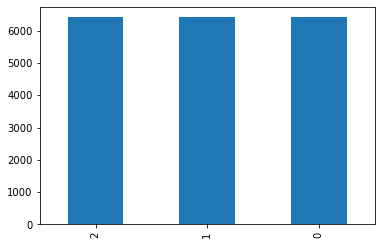

In [ ]:
train_df.fold.value_counts().plot.bar();

## DataBlock 

now that data is in dataframe and also folds are also defined for cross validation, we will build dataloaders, for which we will use datablock.

If you want to learn how fastai datablock see my blog series [Make code Simple with DataBlock api](https://kirankamath.netlify.app/blog/fastais-datablock-api/)

we will create a function get_data to create dataloader.

get_data uses fold to split data to be used for cross validation using IndexSplitter. 
for multiLabel problem compared to single only extra thing to be done is to add MultiCategoryBlock in blocks, this is how fastai makes it easy to work.

In [ ]:
def get_data(fold=0, size=224,bs=32):
    return DataBlock(blocks=(ImageBlock,MultiCategoryBlock),
                       get_x=ColReader(0),
                       get_y=ColReader(1, label_delim=' '),
                       splitter=IndexSplitter(train_df[train_df.fold == fold].index),
                       item_tfms=[FlipItem(p=0.5),Resize(512,method='pad')],
                   batch_tfms=[*aug_transforms(size=size,do_flip=True, flip_vert=True, max_rotate=180.0, max_lighting=0.6,max_warp=0.1, p_affine=0.75, p_lighting=0.75,xtra_tfms=[RandomErasing(p=0.5,sh=0.1, min_aspect=0.2,max_count=2)]),Normalize],
                      ).dataloaders(train_df, bs=bs)

## metrics

Since this is multi label problem normal accuracy function wont work, so we have accuracy_multi. fastai has this which we can directly use in metrics but I wanted to know how that works so took code of it.

In [ ]:
def accuracy_multi(inp, targ, thresh=0.5, sigmoid=True):
    "Compute accuracy when `inp` and `targ` are the same size."
    if sigmoid: inp = inp.sigmoid()
    return ((inp>thresh)==targ.bool()).float().mean()

F_score is way of evaluation for this competition so used this.

In [ ]:
def F_score(output, label, threshold=0.2, beta=1):
    prob = output > threshold
    label = label > threshold

    TP = (prob & label).sum(1).float()
    TN = ((~prob) & (~label)).sum(1).float()
    FP = (prob & (~label)).sum(1).float()
    FN = ((~prob) & label).sum(1).float()

    precision = torch.mean(TP / (TP + FP + 1e-12))
    recall = torch.mean(TP / (TP + FN + 1e-12))
    F2 = (1 + beta**2) * precision * recall / (beta**2 * precision + recall + 1e-12)
    return F2.mean(0)

## Gathering test set

In [ ]:
test_df = pd.read_csv('../input/jovian-pytorch-z2g/submission.csv')
tstpng = test_df.copy()
tstpng['Image'] = tstpng['Image'].apply(str) + ".png"
tstpng['Image'] = "../input/jovian-pytorch-z2g/Human protein atlas/test/" + tstpng['Image']
tstpng.head()

,Image,Label
0,../input/jovian-pytorch-z2g/Human protein atlas/test/24117.png,0
1,../input/jovian-pytorch-z2g/Human protein atlas/test/15322.png,0
2,../input/jovian-pytorch-z2g/Human protein atlas/test/14546.png,0
3,../input/jovian-pytorch-z2g/Human protein atlas/test/8079.png,0
4,../input/jovian-pytorch-z2g/Human protein atlas/test/13192.png,0


## Training

I have used technique called mixup, its a data augmentation technique. 

In fastai Mixup is callback, and
this Callback is used to apply MixUp data augmentation to your training.
to know more read [this](http://dev.fast.ai/callback.mixup)

I have tried this first time, but this technique didnot improve my result in this problem. It usually improves accuracy after 80 epochs but I have trained for 20 epoches. so there was no difference in accuracy without it. so you can ignore this. 

But to know about how mixup works is good, I will separate blog on this, so follow my twitter for updates.

In [ ]:
mixup = MixUp(0.3)

gc is for garbage collection

In [ ]:
import gc

I have created 3 folds where I simply get the data from a particular fold, create a model, add metrics, I have used resnet34.
And that's the whole training process. I just trained model on each fold and saved predictions for the test set.

I have used a technique called progressive resizing. 

this is very simple: start training using small images, and end training using large images. Spending most of the epochs training with small images, helps training complete much faster. Completing training using large images makes the final accuracy much higher. this approach is called progressive resizing.

we should use the `fine_tune` method after we resize our images to get our model to learn to do something a little bit different from what it has learned to do before. 

I have used `cbs=EarlyStoppingCallback(monitor='valid_loss')` so that model doesnot overfit.

append all prediction to list so that we use it later.

I have run the model for less epochs to see code works and show result, or stopped model in between(it took so much time)

This method gave me F_score of `.77` and accuracy of `>91%` so you can try.

My Purpose here is to write blog and explain how to approach and how code works.

If GPU is out of memory delete learner and empty cuda cache done in last line of code.

In [ ]:
all_preds = []

for i in range(3):
    dls = get_data(i,256,64)
    learn = cnn_learner(dls, resnet34, metrics=[partial(accuracy_multi, thresh=0.2),partial(F_score, threshold=0.2)],cbs=mixup).to_fp16()
    learn.fit_one_cycle(10, cbs=EarlyStoppingCallback(monitor='valid_loss'))
    learn.dls = get_data(i,512,32)
    learn.fine_tune(10,cbs=EarlyStoppingCallback(monitor='valid_loss'))
    tst_dl = learn.dls.test_dl(tstpng)
    preds, _ = learn.get_preds(dl=tst_dl)
    all_preds.append(preds)
    del learn
    torch.cuda.empty_cache()
    gc.collect()

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/checkpoints/resnet34-333f7ec4.pth


epoch,train_loss,valid_loss,accuracy_multi,F_score,time
0,0.545962,0.344541,0.796662,0.325269,03:34


epoch,train_loss,valid_loss,accuracy_multi,F_score,time
0,0.383005,0.320621,0.838335,0.343538,03:31
1,0.364457,0.307868,0.834389,0.395574,03:29
2,0.339153,0.288834,0.851154,0.424101,03:30
3,0.321231,0.276498,0.860605,0.500714,03:29
4,0.307015,0.262529,0.865237,0.526143,03:29
5,0.303211,0.252637,0.869339,0.542609,03:29
6,0.293627,0.246137,0.870898,0.557622,03:28
7,0.288911,0.240489,0.877324,0.567245,03:29
8,0.285248,0.237112,0.876575,0.589500,03:28
9,0.286031,0.236534,0.877339,0.590382,03:27


epoch,train_loss,valid_loss,accuracy_multi,F_score,time
0,0.290949,0.315076,0.849766,0.462833,04:23
1,0.295474,0.320369,0.826154,0.472169,04:22


No improvement since epoch 0: early stopping


epoch,train_loss,valid_loss,accuracy_multi,F_score,time
0,0.554367,0.340495,0.808827,0.318601,03:22


epoch,train_loss,valid_loss,accuracy_multi,F_score,time
0,0.388593,0.319564,0.840362,0.331533,03:32
1,0.366437,0.307622,0.839379,0.363208,03:28
2,0.343576,0.290248,0.840876,0.402298,03:27
3,0.325350,0.281427,0.846164,0.467070,03:28
4,0.314482,0.266823,0.859451,0.469782,03:27
5,0.305747,0.257310,0.865830,0.517662,03:29
6,0.295284,0.248361,0.871881,0.546668,03:27
7,0.287226,0.242251,0.874298,0.563557,03:27
8,0.288487,0.239550,0.878041,0.570435,03:27
9,0.284914,0.238145,0.879196,0.570799,03:27


epoch,train_loss,valid_loss,accuracy_multi,F_score,time
0,0.294379,0.344038,0.817124,0.550201,04:22
1,0.296755,0.330813,0.830053,0.424398,04:20
2,0.295352,0.260328,0.866110,0.477913,04:23
3,0.280896,0.259668,0.857954,0.598846,04:19
4,0.273494,0.218607,0.878868,0.645609,04:22
5,0.259204,0.200595,0.905396,0.653470,04:20
6,0.247184,0.209090,0.889878,0.687422,04:19


No improvement since epoch 5: early stopping


epoch,train_loss,valid_loss,accuracy_multi,F_score,time


stack all the prediction stored in list and average the values.

In [ ]:
subm = pd.read_csv("../input/jovian-pytorch-z2g/submission.csv")
preds = np.mean(np.stack(all_preds), axis=0)

You should have list of labels which we get using vocab.

In [ ]:
k = dls.vocab

In [ ]:
preds[0]

array([0.04565947, 0.08774102, 0.0536039 , 0.04304133, 0.9251135 ,
       0.01606368, 0.15841891, 0.02610746, 0.09389433, 0.06638951],
      dtype=float32)

I found threshold of 0.2 works good for my code.

then all the labels predicted above 0.2 are labels of that image using vocab. 

In [ ]:
thresh=0.2
labelled_preds = [' '.join([k[i] for i,p in enumerate(pred) if p > thresh]) for pred in preds]

put them in Labels column

In [ ]:
test_df['Label']=labelled_preds

this step is to submit result to kaggle.

In [ ]:
test_df.to_csv('submission.csv',index=False)